In [1]:
import os
import sys
import warnings
from pathlib import Path
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import torch
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine.defaults import DefaultPredictor
from detectron2.structures import BitMasks, Boxes, Instances
from detectron2.utils.visualizer import Visualizer, VisImage
from yacs.config import CfgNode

CWD = [p for p in Path().resolve().parents if p.stem == "eco-nsr"][0]
sys.path.append(CWD.as_posix())

In [2]:
from src.data.dataset_registration import register_dataset_json
from src.segmentation.custom_dataloader import inference_mapper
from src.segmentation.utils import seed_everything

with warnings.catch_warnings():
    """
    detectron2.model_zoo uses pkg_resources which is deprecated. Setuptools<81 has been pinned in requirements.txt.
    """
    warnings.simplefilter(action="ignore", category=UserWarning)
    from src.segmentation.config import inf_config

In [3]:
def apply_score_threshold(instances: Instances, threshold: float) -> Instances:
    """
    Apply a score threshold to ``instances`` by filtering out instances with scores below the threshold.

    Parameters
    ----------
    instances : Instances
        The input instances to filter.
    threshold : float
        The score threshold for filtering instances.

    Returns
    -------
    Instances
        A new Instances object created from a list of the single instances above the threshold.
    """
    ret: list[Instances] = []
    for instance in [instances[i] for i in range(len(instances))]:
        if instance.scores.item() >= threshold:
            ret.append(instance)
    return Instances.cat(ret)  # pyright: ignore[reportArgumentType]


def vis_annos(sample : dict, img : np.ndarray) -> VisImage:
    """
    Turn image annotations (i.e. labels) into a visualization comparable to the model predictions.

    Parameters
    ----------
    sample : dict
        Unmapped sample data-dictionary, containing informations on annotations and image size
    img : np.ndarray
        Image array to visualize the annotations on

    Returns
    -------
    VisImage
        Visualization of the image with annotations.
    """
    pred_boxes = []
    scores = []
    pred_classes = []
    pred_masks = []

    for anno in sample["annotations"]:
        pred_boxes.append(
            [
                anno["bbox"][0],
                anno["bbox"][1],
                anno["bbox"][0] + anno["bbox"][2],
                anno["bbox"][1] + anno["bbox"][3],
            ]
        )
        scores.append(1.0)
        pred_classes.append(anno["category_id"])
        pred_masks.append(
            BitMasks.from_polygon_masks(
                [anno["segmentation"]], sample["height"], sample["width"]
            ).tensor
        )

    pred_boxes = Boxes(torch.tensor(pred_boxes, dtype=torch.float32))
    scores = torch.tensor(scores, dtype=torch.float32)
    pred_classes = torch.tensor(pred_classes, dtype=torch.int64)
    pred_masks = torch.cat(pred_masks, dim=0)

    inst = Instances(
        (sample["height"], sample["width"]),
        pred_boxes=pred_boxes,
        scores=scores,
        pred_classes=pred_classes,
        pred_masks=pred_masks,
    )

    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2)
    return v.draw_instance_predictions(inst.to("cpu"))

In [4]:
with open(os.path.join(CWD, "global_cfg.yml"), "r") as f:
    global_cfg = CfgNode.load_cfg(f)

seed_everything(global_cfg.SEGMENTATION.TRAINING.seed)
register_dataset_json(global_cfg.DATA.path)

cfg = inf_config(global_cfg)

predictor = DefaultPredictor(cfg)
ds = DatasetCatalog.get(cfg.DATASETS.TEST[0])
samples = sample(ds, 5)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



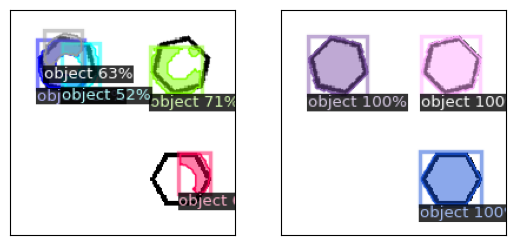

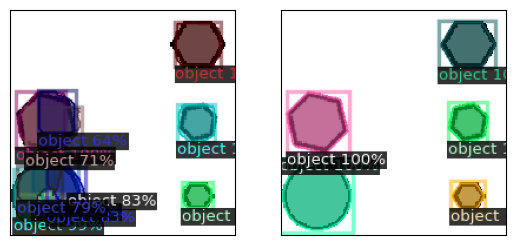

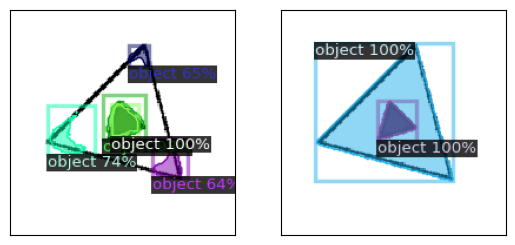

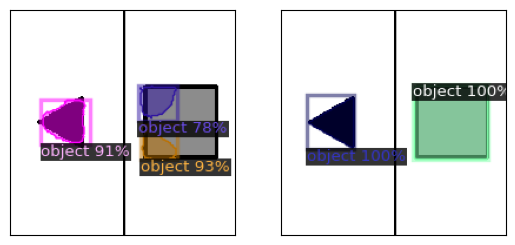

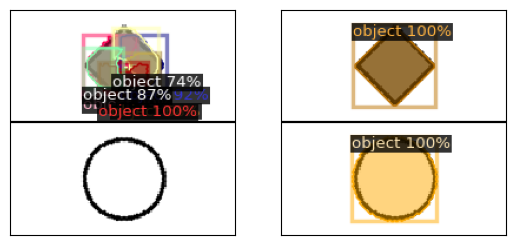

In [5]:
for s in samples:
    # plt.figure()

    s_mapped = inference_mapper(s)

    img = s_mapped["image"]

    with warnings.catch_warnings():
        """
        UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument.
        return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
        """
        warnings.simplefilter(action="ignore", category=UserWarning)
        instances = predictor(img)["instances"]

    instances = apply_score_threshold(instances, 0.5)

    v = Visualizer(
        img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=1.2
    )
    pred = v.draw_instance_predictions(instances.to("cpu"))

    label = vis_annos(s, img)

    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(pred.get_image()[:, :, ::-1])
    axs[1].imshow(label.get_image()[:, :, ::-1])

    for ax in axs:
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)

    plt.show()
plt.close()